# Classification and Feature Selection
By Elliot Cohen, PhD
## Part 1: Data Science with Python 
### Data Basics

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn import linear_model
from sklearn.cluster import KMeans
from scipy.stats import ttest_ind
from xgboost import XGBClassifier

In [2]:
# Q: Load in the data file and header file provided
header_url = 'https://gist.githubusercontent.com/jeff-boykin/b5c536467c30d66ab97cd1f5c9a3497d/raw/5233c792af49c9b78f20c35d5cd729e1307a7df7/field_names.txt'
header_list = pd.read_csv(header_url, header=None, squeeze=True).tolist();

data_url = 'https://gist.githubusercontent.com/jeff-boykin/b5c536467c30d66ab97cd1f5c9a3497d/raw/5233c792af49c9b78f20c35d5cd729e1307a7df7/breast-cancer.csv'
data = pd.read_csv(data_url, header=None, names=header_list, index_col='ID')

In [3]:
# Q: Comment on any steps you might take to evaluate or transform the dataset.
# A: Converting the dataframe to pandas built-in type Categorical can be helpful for summary statistics.
#    It is also helpful when working with large datasets with repeated values, 
#    although that is not required here due to the relatively small sample size of our data.
data.apply(pd.Categorical).describe()

,diagnosis,radius_mean,radius_sd_error,radius_worst,texture_mean,texture_sd_error,texture_worst,perimeter_mean,perimeter_sd_error,perimeter_worst,...,concavity_worst,concave_points_mean,concave_points_sd_error,concave_points_worst,symmetry_mean,symmetry_sd_error,symmetry_worst,fractal_dimension_mean,fractal_dimension_sd_error,fractal_dimension_worst
count,569,569.00,569.00,569.0,569.0,569.0000,569.0000,569.0,569.0,569.0000,...,569.00,569.00,569.0,569.0,569.0000,569.0000,569.0,569.0,569.0000,569.00000
unique,2,456.00,479.00,522.0,539.0,474.0000,537.0000,537.0,542.0,432.0000,...,457.00,511.00,514.0,544.0,411.0000,529.0000,539.0,492.0,500.0000,535.00000
top,B,12.34,18.22,134.7,512.2,0.1007,0.1147,0.0,0.0,0.1714,...,12.36,27.26,101.7,826.4,0.1216,0.1486,0.0,0.0,0.2383,0.07427
freq,357,4.00,3.00,3.0,3.0,5.0000,3.0000,13.0,13.0,4.0000,...,5.00,3.00,3.0,2.0,4.0000,3.0000,13.0,13.0,3.0000,3.00000


In [4]:
# Q: Compute the mean and median smoothness and compactness for benign and malignant tumors
data.filter(regex='smoothness|compactness|diagnosis').groupby('diagnosis').agg(['mean', 'median'])

smoothness_mean         smoothness_sd_error          \
                     mean  median                mean  median   
diagnosis                                                       
B                2.000321  1.8510           21.135148  19.630   
M                4.323929  3.6795           72.672406  58.455   

          smoothness_worst           compactness_mean           \
                      mean    median             mean   median   
diagnosis                                                        
B                 0.007196  0.006530         0.021438  0.01631   
M                 0.006780  0.006209         0.032281  0.02859   

          compactness_sd_error           compactness_worst            
                          mean    median              mean    median  
diagnosis                                                             
B                     0.025997  0.018400          0.009858  0.009061  
M                     0.041824  0.037125          0.015060  0.014205

In [5]:
# Q: Do the groups differ? Explain how you would identify this.
# A: Perform a T-test on the means of two independent samples. 
#    This is a univariate test, and can be done for each predictor, as needed.
grouped = data.groupby('diagnosis')
malignant = data.loc[grouped.groups['M']]
benign = data.loc[grouped.groups['B']]

t, p = ttest_ind(malignant['smoothness_mean'], benign['smoothness_mean']) 
print('{}: t statitic = {:.6f} p value = {:.9f}'.format('smoothness', t, p))

t, p = ttest_ind(malignant['compactness_mean'], benign['compactness_mean'])
print('{}: t statitic = {:.6f} p value = {:.9f}'.format('compactness', t, p))

smoothness: t statitic = 15.934158 p value = 0.000000000
compactness: t statitic = 7.297077 p value = 0.000000000


Grouping the cancer data by diagnosis, and summarizing by smoothness and compactness features, we see a discernable difference in measures of central tendancy (e.g. mean and median). To determine if this difference is statistically significant, we conduct a two-sided T-test with a null hypothesis that the two independent samples are identically distributed.

Results indicate that we can __reject the null hypothesis__ that mean cell nuclei smoothness for benign and malignant tupors are the same, based on a p_value approaching zero. Similarly for compactness, we can reject the null hypthoses that benign and malignant cell nuclei compactness are the same.

In [6]:
# Q: Write a function to generate bootstrap samples of the data.
def create_bootstrap_samples_from_dataframe(dataframe, n_samples=1000):
    assert isinstance(dataframe, pd.core.frame.DataFrame), 'input data must be a pandas dataframe'
    return dataframe.sample(n=n_samples, replace=True)

# A: Example usage
bootstrap_data = create_bootstrap_samples_from_dataframe(data, n_samples=10000)
print('original smoothness for benign cells: {:.6f}'.format(data[data['diagnosis']=='B']['smoothness_mean'].mean()))
print('resampled smoothness for benign cells: {:.6f}'.format(bootstrap_data[bootstrap_data['diagnosis']=='B']['smoothness_mean'].mean()))

original smoothness for benign cells: 2.000321
resampled smoothness for benign cells: 1.987058


### Exploratory Analysis
Q: Identify 2-3 variables that are predictive of a malignant tumor. Display the relationship visually and write 1-2 sentences explaining the relationship.

A: To identify the most important predictive features, I will use one of sklearn's built-in feature selection methods. They are powerful and fast -- ideal for exploratory analysis. We can always come back to tune hyperparameters and thresholds later, as needed.

In [7]:
# first divide data into predictors (X) and predictand (y), and subdivide into test/train sets.
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

Y = data['diagnosis'].replace({'M': True, 'B': False}) # convert to binary outcome
X = data.iloc[:, data.columns != 'diagnosis']

scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

x_train, x_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.4)

In [8]:
# verify that scaled predictors are mean zero and standard deviation 1
tolerance = 1*10**-5
assert all(abs(X_scaled.mean(axis=0) - 0) <= tolerance) # verify that scaled mean ~=0
assert all(abs(X_scaled.std(axis=0) - 1) <= tolerance) # verify that scaled std ~=1

In [9]:
# select top k predictors
from sklearn.feature_selection import SelectKBest, f_classif

k = 3
selector = SelectKBest(f_classif, k)
selector.fit(x_train, y_train)

idxs_selected = selector.get_support(indices=True) # get indices of columns to keep
best_predictors = X.columns[idxs_selected]
print('top {} predictors: {}'.format(k, best_predictors.values))

top 3 predictors: ['concavity_worst' 'concave_points_sd_error' 'fractal_dimension_mean']


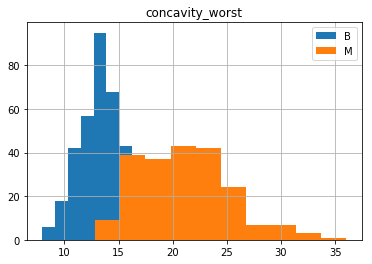

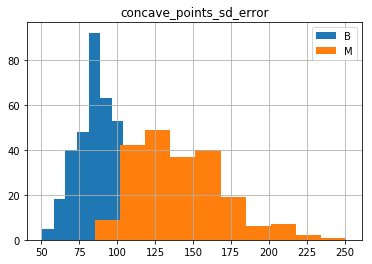

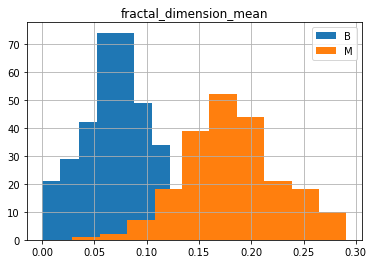

In [10]:
# visual inpsection
for predictor in best_predictors:
    for group in data.groupby('diagnosis'):
        group[1][predictor].hist(label=group[0])
        plt.title(predictor)
        plt.legend()
    plt.show()

Visual inpsection confirms the results of our feature selection -- we can see that the distribution of values are indeed different between benign and malignant cells. This differentiation is what allows them to be useful predictors.

For all three predictors -- concavity worst, concave points standard error and fractal dimenension mean -- malignant cells have a higher mean, median and modal value compared to benign cells. The variance also appears to be greater for malignant compared to benign cells.

### Modeling
Build a model to predict the malignant tumors.
Use at least two classification techniques; compare and contrast the advantages and disadvantages of each.
Identify how you would control for overfitting in each classification technique.
Evaluate the performance of each model.
In each model, identify the most important predictive variables and explain how you identified them.

In [11]:
def compute_classification_error(y_true, y_hat):
    accuracy = accuracy_score(y_true, y_hat)

    scorecard = pd.DataFrame({'y_hat': y_hat, 'y_true': y_true})
    false_positives = scorecard[(scorecard['y_true'] == 0) & (scorecard['y_hat'] == 1)]
    false_negatives = scorecard[(scorecard['y_true'] == 1) & (scorecard['y_hat'] == 0)]
    type_1_error = len(false_positives)/len(scorecard)
    type_2_error = len(false_negatives)/len(scorecard)

    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    print('Type I error rate: {:.5f}'.format(type_1_error *100.0))
    print('Type II error rate: {:.5f}'.format(type_2_error *100.0))

In [12]:
# Technique 1: Logistic regression
classifier = linear_model.LogisticRegression(penalty='l1', class_weight='balanced')
probability_by_class = classifier.fit(x_train, y_train).predict_proba(x_test)
y_hat = probability_by_class[:,0] < 0.68  # if probability of being in class M is greater than 0.68, classify as M.

compute_classification_error(y_true=y_test, y_hat=y_hat)

Accuracy: 96.93%
Type I error rate: 2.63158
Type II error rate: 0.43860


In [13]:
# Technique 2: Gradient Boosted Trees
model = XGBClassifier()
model.fit(x_train, y_train)
y_hat = model.predict(x_test)

compute_classification_error(y_true=y_test, y_hat=y_hat)

Accuracy: 96.93%
Type I error rate: 1.31579
Type II error rate: 1.75439


In [14]:
# Technique 3: clustering
kmeans = KMeans(n_clusters=2, random_state=0).fit(x_train)
y_hat = kmeans.predict(x_test)

compute_classification_error(y_true=y_test, y_hat=y_hat)

Accuracy: 90.35%
Type I error rate: 1.75439
Type II error rate: 7.89474


In [15]:
# feature importance (for XGboost only)
feature_importance = pd.DataFrame({'Feature': X.columns, 'Feature_importance': model.feature_importances_})
feature_importance.sort_values('Feature_importance', ascending=False).head()

,Feature,Feature_importance
21,concave_points_mean,0.120301
1,radius_sd_error,0.120301
23,concave_points_worst,0.115288
13,smoothness_sd_error,0.095238
27,fractal_dimension_mean,0.080201


### Explanation

To Technical Audiences
Explain the limitations of your analysis and identify possible further steps you could take.
To Non-Technical Audiences
Write a short summary of your analysis, explaining how your model works and how it performs.
Briefly explain the factors that contributed to malignant vs benign tumor identification.

**General Audience**: I appled three classification techniques: logistic regression, gradient-boosted trees, and k-means clustering. All three are well-suited to classification problems, but are very different under the hood. Logistic regression is simply a regression model where the dependent variable is categorical; gradient-boosted trees is an ensemble decision tree with a well-defined objective function that includes both a loss function (e.g. MSE) and a regularization term to encourage parsimony and discourage over-fitting; k-means clustering iteratively assigns unlabeled data to one of K groups based on feature similarity.

**Technical Audience**: All three techniques may be improved with a-priori information. In the case of logistic regression, it is useful to pre-select relevant features based on an ojbective criteria such as Akaike's Information Criterion (AIC), Bayesian Information Criterion (BIC) or Univariate Feature Selection. For gradient boosted trees, performance may be improved by hyperparameter tuning, such as selecting tree depth and the number of trees. In the case of k-means clustering, it is essential to have modeler intuition regarding the number of underlying groups that exist in the data, as given by k. 

## Part 2: Student Code Samples

**Code**: Feel free to comment on style, library usage, or other improvements.  
**Methodology**: Feel free to comment on the student's data setup, modeling methodology, and model evaluation.  
** Conceptual Understanding**: Finally, feel free to add any suggestions or takeaways on how the student could continue to improve their understanding of these concepts.